In [1]:
%load_ext autoreload

### VAE

In [2]:
%autoreload 2
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from vae import VAE, Classifier, Reward

In [16]:
def dirichlet_reward(target_values, alpha=-0.01, max_reward: float = 5.0):
    if target_values.shape[1] == 1:
        return target_values.squeeze(1)

    x = target_values / target_values.sum(dim=1, keepdim=True)
    alphas = torch.ones_like(x) * alpha
    
    return torch.minimum(x ** alphas, torch.as_tensor(max_reward)).prod(dim=1)

In [17]:
target_values = torch.rand(32, 5)
dirichlet_reward(target_values)

tensor([1.1017, 1.1011, 1.0901, 1.0984, 1.1169, 1.1018, 1.1049, 1.0860, 1.0923,
        1.0982, 1.0873, 1.1062, 1.0960, 1.0915, 1.1333, 1.0859, 1.0882, 1.0842,
        1.0854, 1.0850, 1.0855, 1.1110, 1.1212, 1.1107, 1.0963, 1.0860, 1.0994,
        1.1133, 1.0843, 1.0905, 1.1224, 1.0967])

In [3]:
vae = VAE()
optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-3)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

dataset = MNIST('../datasets', train=True, download=False, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

val_dataset = MNIST('../datasets', train=False, download=False, transform=transform)
val_dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [4]:
n_epochs = 10
vae.train()
for epoch in range(n_epochs):
    for i, (x, _) in enumerate(dataloader):
        optimizer.zero_grad()
        loss, l2, kl = vae.compute_loss(x, kl_weight=1.0)
        loss.backward()
        optimizer.step()

    print(
        f'Epoch {epoch+1}/{n_epochs}, Step {i}, Loss: {loss.item():.4f}'
        f', L2: {l2.item():.4f}, KL: {kl.item():.4f}'
    )

Epoch 1/10, Step 937, Loss: 34.0081, L2: 27.6158, KL: 6.3924
Epoch 2/10, Step 937, Loss: 34.7346, L2: 27.2695, KL: 7.4651
Epoch 3/10, Step 937, Loss: 33.2748, L2: 25.1077, KL: 8.1671
Epoch 4/10, Step 937, Loss: 28.2225, L2: 20.1689, KL: 8.0536
Epoch 5/10, Step 937, Loss: 31.1663, L2: 23.2020, KL: 7.9643
Epoch 6/10, Step 937, Loss: 28.7820, L2: 20.3453, KL: 8.4367
Epoch 7/10, Step 937, Loss: 30.1849, L2: 21.2167, KL: 8.9681
Epoch 8/10, Step 937, Loss: 27.8980, L2: 19.3229, KL: 8.5751
Epoch 9/10, Step 937, Loss: 26.1227, L2: 17.2488, KL: 8.8739
Epoch 10/10, Step 937, Loss: 29.2388, L2: 19.6644, KL: 9.5744


In [6]:
torch.save(
    vae.state_dict(),
    "../assets/checkpoints/vae/vae_mnist.pth"
)

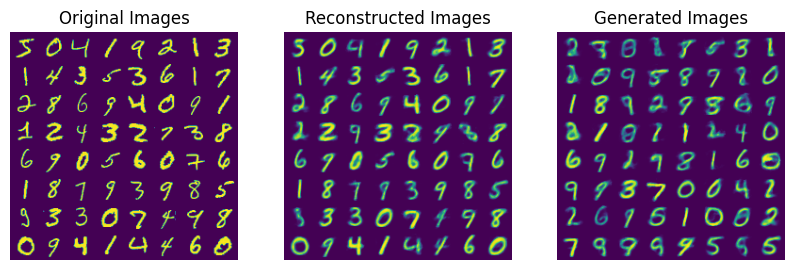

In [ ]:
x_eval, _ = next(iter(val_dataloader))
x_pred, *_ = vae(x_eval)
x_pred = x_pred.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

x_ = x_eval.reshape(-1, 1, 28, 28).repeat(1, 3, 1, 1)
ax[0].set_title('Original Images')
ax[0].imshow(make_grid(x_, nrow=8, normalize=True)[0])
ax[0].axis('off')

ax[1].set_title('Reconstructed Images')
ax[1].imshow(make_grid(x_pred, nrow=8, normalize=True)[0])
ax[1].axis('off')

with torch.no_grad():
    z = torch.randn(64, 10)
    x_gen = vae.decoder(z)
    x_gen = x_gen.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
ax[2].set_title('Generated Images')
ax[2].imshow(make_grid(x_gen, nrow=8, normalize=True)[0])
ax[2].axis('off')

plt.show()

### Classification

In [14]:
cls_model = Classifier(784, 10)

cls_opt = torch.optim.AdamW(cls_model.parameters(), lr=1e-3)

In [15]:
n_epochs = 10
for epoch in range(n_epochs):
    for i, (x, y) in enumerate(dataloader):
        cls_opt.zero_grad(set_to_none=True)
        
        if torch.rand(1) < 0.5:
            x, *_ = vae(x)

        logits = cls_model(x)

        loss = nn.CrossEntropyLoss()(logits, y)
        loss.backward()
        cls_opt.step()

    print(f'Epoch {epoch+1}/{n_epochs}, Step {i}, Loss: {loss.item():.4f}')

/Users/ktamogashev/miniforge/envs/torchcfm/lib/python3.10/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/10, Step 937, Loss: 1.5574
Epoch 2/10, Step 937, Loss: 1.5229
Epoch 3/10, Step 937, Loss: 1.5350
Epoch 4/10, Step 937, Loss: 1.4655
Epoch 5/10, Step 937, Loss: 1.4959
Epoch 6/10, Step 937, Loss: 1.4726
Epoch 7/10, Step 937, Loss: 1.4614
Epoch 8/10, Step 937, Loss: 1.4855
Epoch 9/10, Step 937, Loss: 1.5242
Epoch 10/10, Step 937, Loss: 1.5415


In [16]:
sum_, num = 0.0, 0.0
for x, y in val_dataloader:
    logits = cls_model(x)
    y_pred = logits.argmax(dim=1)
    
    sum_ += (y_pred == y).float().sum()
    num += y.size(0)

print(f'Accuracy: {sum_ / num:.4f}')
torch.save(
    cls_model.state_dict(),
    "../assets/checkpoints/vae/cls.pth"
)

Accuracy: 0.9735


In [17]:
reward_state_dict = vae.state_dict() | cls_model.state_dict()
torch.save(reward_state_dict, "../assets/checkpoints/vae/reward.pth")

In [30]:
r = Reward(5)
r.load_state_dict(reward_state_dict)
r.eval()

z = torch.randn(64, 10)
y = 5

reward = r(z)
(reward.reshape(8, 8) * 1000).round() / 1000


tensor([[0.7400, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.5250],
        [0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9450, 0.0000, 1.0000, 0.0000, 0.9920, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0010, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9010, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3140]])

(np.float64(-0.5), np.float64(241.5), np.float64(241.5), np.float64(-0.5))

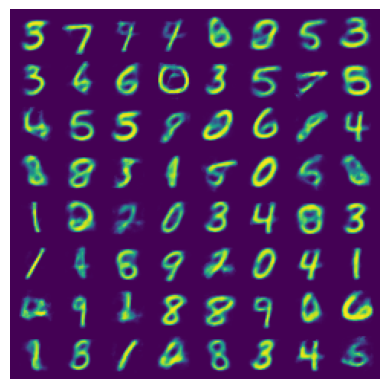

In [31]:
x = vae.decoder(z)
x = x.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
plt.imshow(make_grid(x, nrow=8, normalize=True)[0])
plt.axis('off')